In [1]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is available


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from random import sample
from functools import reduce
import copy
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from random import random
from tensorflow.keras import backend as K
from keras.backend import sign

sns.set(style="dark")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DOL/Project1/

/content/drive/MyDrive/DOL/Project1


In [7]:
!git clone https://github.com/sevgicansalih/nwdaf_data

Cloning into 'nwdaf_data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 4), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (19/19), 13.79 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [8]:
data = pd.read_csv('nwdaf_data/nwdaf_data.csv')
data = data.drop(columns='has_anomaly')

In [10]:
cell0 = data.loc[data['cell_id']==0]
cell1 = data.loc[data['cell_id']==1]
cell2 = data.loc[data['cell_id']==2]
cell3 = data.loc[data['cell_id']==3]
cell4 = data.loc[data['cell_id']==4]

In [11]:
week = 4*24*7

In [12]:
load_cell0 = cell0.groupby('t')['load'].sum()[:8*week]
load_cell1 = cell1.groupby('t')['load'].sum()[:8*week]
load_cell2 = cell2.groupby('t')['load'].sum()[:8*week]
load_cell3 = cell3.groupby('t')['load'].sum()[:8*week]
load_cell4 = cell4.groupby('t')['load'].sum()[:8*week]

In [13]:
load_cells=[load_cell0, load_cell1, load_cell2, load_cell3, load_cell4]

In [14]:
look_back = week
def df_to_X_y(df, look_back=5):
  # df_as_np = df.to_numpy()
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-look_back):
    row = [[a] for a in df_as_np[i:i+look_back]]
    X.append(row)
    label = df_as_np[i+look_back]
    y.append(label)
  return np.array(X), np.array(y)

In [15]:
class Client():
  def __init__(self, cid, load_cell, n_epoch = 1, n_batch = 64, lr=0.001, validation_split = 0.2, verbosity = 2, attack="pgd", attack_rate=0.3, use_fedprox=False, fedprox_mu=0.1):
    self.cid = cid
    self.scaler = MinMaxScaler()

    load_cell = load_cell.to_numpy().reshape(-1, 1)
    self.scaled_load_cell = self.scaler.fit_transform(load_cell)
    x_cell, y_cell = df_to_X_y(self.scaled_load_cell, look_back)
    self.x_train, self.x_test, self.y_train, self.y_test= train_test_split(x_cell, y_cell, test_size=0.2, shuffle=False)
    self.x_train = self.x_train.reshape(self.x_train.shape[0],self.x_train.shape[1],self.x_train.shape[2])
    self.x_test = self.x_test.reshape(self.x_test.shape[0],self.x_test.shape[1],self.x_test.shape[2])

    self.n_epoch = n_epoch
    self.n_batch = n_batch
    self.lr = lr
    self.validation_split = validation_split
    self.verbosity = verbosity
    self.loss_function = MeanSquaredError()
    self.metrics = RootMeanSquaredError()
    self.optimizer = Adam(learning_rate = self.lr)
    self.robustness = Robustness()
    self.attack=attack
    self.attack_rate = attack_rate
    self.use_fedprox = use_fedprox
    self.fedprox_mu=fedprox_mu
    print(f"client {cid} initilized.")

  def _create_model(self):
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.3))
    model.add(Dense(units = 8, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = 'linear'))
    return model

  def _model_compile(self):

    self.model.compile(loss=self.loss_function, optimizer= self.optimizer, metrics=[self.metrics])
  def fedprox_loss(self, y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-1) + sum(self.fedprox_reg)


  def fit(self, weights):
    """Local training.
        Returns:
            1) a list of np.ndarray which corresponds to local learned weights
            2) the number of local instances
            5) the local test loss
    """
    if weights == None:
      self.model = self._create_model()
    else:
      if self.use_fedprox:
        self.fedprox_reg = [0.5 * self.fedprox_mu * np.linalg.norm(p - g) ** 2 for p, g in zip(self.get_weights(), weights)]
        self.loss_function = self.fedprox_loss

      self.model.set_weights(weights)

    self._model_compile()

    if random() < self.attack_rate:
      print(f"client {self.cid} is using adversarial attacks")
      y_pred = self.predict(self.x_train).reshape(-1,1)
      loss = MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(self.y_train, y_pred)
      if self.attack == "pgd":
        x_train= self.robustness.PGD(x=self.x_train, loss= loss, epsilon= 0.1, steps=2)
      elif self.attack == "fgsm":
        x_train= self.robustness.FGSM_np(x=self.x_train, loss= loss, epsilon= 0.1)

    else:
      x_train=self.x_train

    model_histoty = self.model.fit(x_train, self.y_train, epochs=self.n_epoch, batch_size=self.n_batch, shuffle=False, verbose= self.verbosity, validation_split= self.validation_split)
    return self.get_weights(), self.x_train.shape[0], self.evaluate_train(), self.evaluate_test(), model_histoty

  def predict(self, x):
    return self.model.predict(x).flatten()

  def evaluate_test(self):
    cell_predictions = self.predict(self.x_test)
    cell_results = pd.DataFrame(data={'Test Predictions':cell_predictions, 'Actuals':self.y_test.reshape(self.y_test.shape[0])})
    inv_pred_cell = self.scaler.inverse_transform(cell_results['Test Predictions'].to_numpy().reshape(-1,1))
    inv_acc_cell = self.scaler.inverse_transform(cell_results['Actuals'].to_numpy().reshape(-1,1))
    return mean_squared_error(y_pred=inv_pred_cell, y_true=inv_acc_cell)

  def evaluate_train(self):
    cell_predictions = self.predict(self.x_train)
    cell_results = pd.DataFrame(data={'Test Predictions':cell_predictions, 'Actuals':self.y_train.reshape(self.y_train.shape[0])})
    inv_pred_cell = self.scaler.inverse_transform(cell_results['Test Predictions'].to_numpy().reshape(-1,1))
    inv_acc_cell = self.scaler.inverse_transform(cell_results['Actuals'].to_numpy().reshape(-1,1))
    return mean_squared_error(y_pred=inv_pred_cell, y_true=inv_acc_cell)


  def get_weights(self):
    allLayersWeights = self.model.get_weights()
    return allLayersWeights

  def set_weights(self, w):
    self.model.set_weights(w)

In [18]:
def initialize_clients(num_clients, n_epoch = 1, n_batch = 64, lr=0.001, validation_split = 0.2, verbosity = 2, attack="pgd", attack_rate=0.3, use_fedprox=False, fedprox_mu=0.1):
  print("Initializing clients ...")
  clients = dict()
  for cid in range(num_clients):
    clients[cid] = Client(cid=cid,
                          load_cell=load_cells[cid],
                          n_epoch = n_epoch,
                          n_batch = n_batch,
                          lr=lr,
                          validation_split = validation_split,
                          verbosity = verbosity,
                          attack=attack,
                          attack_rate=attack_rate,
                          use_fedprox=use_fedprox,
                          fedprox_mu=fedprox_mu
                          )
  print("Clients initialized!")
  return clients

In [19]:
class Aggregator():
  def __init__(self, aggregation_alg):
    self.aggregation_alg = aggregation_alg
    self.v_t = None
    self.m_t = None


  def aggregate(self, result, model):
    if self.aggregation_alg == "fedavg":
      aggregated = self.fedavg_aggregate(result)
    elif self.aggregation_alg == "fedprox":
      aggregated = self.fedprox_aggregate(results=result)
    elif self.aggregation_alg == "fedadam":
      aggregated, m_t, v_t = self.fedadam_aggregate(results=result, previous_model= model,
                                                m_t=self.m_t, v_t=self.v_t,
                                                beta_1=0.9 , beta_2= 0.99,
                                                eta = 0.01, tau = 1e-3)
      self.m_t = m_t
      self.v_t = v_t

    return aggregated

  def fedavg_aggregate(self, results):
    """Compute weighted average."""
    # Calculate the total number of examples used during training
    num_examples_total = sum([num_examples for _, num_examples in results])

    # Create a list of weights, each multiplied by the related number of examples
    weighted_weights = [
        [layer * num_examples for layer in weights] for weights, num_examples in results
    ]

    # Compute average weights of each layer
    weights_prime: np.ndarray = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_weights)
    ]
    return weights_prime

  def fedprox_aggregate(self, results):
    # FedProx introduces a proximal term in the objective function, which is a regularization term. The proximal term encourages the local models to stay close to the global model.
    fedavg_aggregated = self.fedavg_aggregate(results)
    return fedavg_aggregated

  def fedadam_aggregate(self, results, previous_model, m_t, v_t, beta_1, beta_2, eta, tau):
    """Compute weighted average according to FedAdam."""
    fedavg_aggregated = self.fedavg_aggregate(results)

    delta_t = [x - y for x, y in zip(fedavg_aggregated, previous_model)]

    if not m_t:
        m_t = [np.zeros_like(x) for x in delta_t]
    m_t = [np.multiply(beta_1, x) + (1 - beta_1) * y for x, y in zip(m_t, delta_t)]

    if not v_t:
        v_t = [np.zeros_like(x) for x in delta_t]
    v_t = [beta_2 * x + (1 - beta_2) * np.multiply(y, y)
           for x, y in zip(v_t, delta_t)]

    new_weights = [
        x + eta * y / (np.sqrt(z) + tau)
        for x, y, z in zip(previous_model, m_t, v_t)
    ]
    return new_weights, m_t, v_t

In [22]:
class Robustness():
  def __init__(self):
    pass

  def FGSM_np(self, x, loss, epsilon):
    # FGSM method in Numpy form
    # Collect the element-wise sign of the data gradient
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient).numpy()

    # Create the perturbed data by adjusting each sample of the input data
    # perturbed_data = x + epsilon*sign_data_gradient
    perturbed_data = np.zeros(x.shape)
    for i in range(len(x)):
      for j in range(len(x[i])):
        perturbed_data[i,j] = x[i,j] + epsilon*sign_data_gradient[i]
    # Return the perturbed data
    return perturbed_data

  # Ref: https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/torchattacks/attacks/pgd.py
  def PGD(self, x, loss, epsilon, steps):
    # Starting at a uniformly random point, which noise is uniform distribution -e,e
    x_noise = x + np.random.uniform(low=-epsilon, high=epsilon)
    x_clip= np.clip(x_noise, a_min=0, a_max=1)
    for _ in range(steps):
      X_perturbed = self.FGSM_np(x=x, loss=loss, epsilon=epsilon)
      delta = np.clip(X_perturbed - x, a_min=-epsilon, a_max=epsilon)
      X_perturbed = np.clip(x + delta, a_min=0, a_max=1)
    # in multiple steps update addverserial data with Projected Gradient Descent.
    # P is Clip operation P(z)= clip(z, x-e, x+e)
    return X_perturbed


In [24]:
class Server:
  def __init__(self, clients, aggregation):

    self.global_model = None
    self.best_model = None
    self.best_loss, self.best_epoch = np.inf, -1
    self.clients = clients

    self.aggregator = Aggregator(aggregation_alg=aggregation)
    print(f"server with {len(clients)} clients and aggregation algorithm {aggregation} is created!")

  def fit(self,num_rounds, fraction):
    """Run federated rounds for num_rounds rounds."""
    self.test_losses = dict()
    self.test_losses[0]=[]
    self.test_losses[1]=[]
    self.test_losses[2]=[]
    self.test_losses[3]=[]
    self.test_losses[4]=[]

    self.train_losses = dict()
    self.train_losses[0]=[]
    self.train_losses[1]=[]
    self.train_losses[2]=[]
    self.train_losses[3]=[]
    self.train_losses[4]=[]

    self.model_histoties = dict()
    self.model_histoties[0]=[]
    self.model_histoties[1]=[]
    self.model_histoties[2]=[]
    self.model_histoties[3]=[]
    self.model_histoties[4]=[]
    for fl_round in range(1, num_rounds + 1):
      # train and replace the previous global model
      self.fit_round(fl_round=fl_round, fraction=fraction)

      # evaluate global model

    # print(f"Best global model found on fl_round={self.best_epoch} with loss={self.best_loss}")

    return self.best_model

  def fit_round(self, fl_round, fraction):
    """Perform a federated round, i.e.,
        1) Select a fraction of available clients.
        2) Instruct selected clients to execute local training.
        3) Receive updated parameters from clients and their corresponding evaluation
        4) Aggregate the local learned weights.
    """
    # Inform clients for local parameters change if any => I suppose clients know everythinga!


    # STEP 1: Select a fraction of available clients
    selected_clients = self.select_client(fraction)

    # STEPS 2-3: Perform local training and receive updated parameters
    num_train_examples = []

    results = []

    for client in selected_clients:
      res = self.fit_client(client, fl_round)
      model_params, num_train, train_loss, test_loss, model_histoty = res
      print(f"Client {client.cid} test loss in round {fl_round} is {test_loss}")
      print(f"Client {client.cid} train loss in round {fl_round} is {train_loss}")
      num_train_examples.append(num_train)
      self.test_losses[client.cid].append(test_loss)
      self.train_losses[client.cid].append(train_loss)
      self.model_histoties[client.cid].append(model_histoty)
      results.append((model_params, num_train))

    # STEP 4: Aggregate local models
    self.global_model = self.aggregate_models(fl_round, results)
    if self.best_model is None:
      self.best_model = copy.deepcopy(self.global_model)

  def select_client(self, fraction):
    available_clients = list(self.clients.keys())
    if len(available_clients) == 0:
      print("Cannot sample clients. The number of available clients is zero.")
      return []
    num_selection = int(fraction * len(available_clients))
    if num_selection <= 0:
      num_selection = 1
    if num_selection > len(self.clients):
      num_selection = len(self.clients)

    sampled_clients = sample(available_clients, num_selection)
    return [self.clients[cid] for cid in sampled_clients]

  def fit_client(self, client, fl_round):
    """Perform local training."""
    if fl_round == 1:
      fit_res = client.fit(None)
    else:
      fit_res = client.fit(weights=self.global_model)

    return fit_res

  def aggregate_models(self, fl_round, results):
    print(f"Global round {fl_round} Aggregating local models...")
    if self.global_model == None: # Just for first round
      self.global_model = self._get_initial_model()
    aggregated_params = self.aggregator.aggregate(results, self.global_model)
    return aggregated_params

  def _get_initial_model(self):
        """Get initial parameters from a random client"""
        random_client = self.clients[0] # It could be random
        client_model = random_client.get_weights()
        return client_model
  def evaluate_global_model(self):
    pass

In [25]:
# Plot each cell loss in test set in each round
def plot_cell_loss(clients, test_losses, alg):
  for cid in range(len(clients)):
    plt.plot(test_losses[cid],label=f"cell {cid}")
  plt.legend()
  plt.title(f"algorithm {alg}")
  plt.show()

In [26]:
def plot_load_cell(clients, alg):
  plt.figure(figsize=(8, 12))

  for cid in range(len(clients)):
    x_test = clients[cid].x_test
    y_test = clients[cid].y_test
    y_pred = clients[cid].predict(x_test)

    cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

    print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                      y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
    plt.subplot(5, 1, cid+1)
    plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
    plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
    plt.xlabel("Sample")
    plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
    plt.legend()
  plt.title(f"algorithm {alg}")
  plt.show()

In [27]:
def calculate_global_loss(clients, losses):
  sum_loss = np.zeros(len(losses[0]))
  for cid in range(len(clients)):
    sum_loss += np.array(losses[cid])
  return sum_loss

In [28]:
def plot_global_test_loss(algorithms, global_loss):
  for alg in algorithms:
    plt.plot(global_loss[alg], label=alg)
  plt.legend()
  plt.title('Global Test loss')
  plt.show()

In [29]:
def plot_global_train_loss(algorithms, global_loss):
  for alg in algorithms:
    plt.plot(global_loss[alg], label=alg)
  plt.legend()
  plt.title('Global Train loss')
  plt.show()

In [30]:
algorithms = ["fedavg","fedadam","fedprox"]

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedavg is created!
Epoch 1/2
48/48 - 19s - loss: 0.1247 - root_mean_squared_error: 0.3531 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2880 - 19s/epoch - 394ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0733 - root_mean_squared_error: 0.2707 - val_loss: 0.0531 - val_root_mean_squared_error: 0.2305 - 4s/epoch - 75ms/step
30/30 [==============================] - 1s 35ms/step
Client 3 test loss in round 1 is 31.01608851624704
Client 3 train loss in round 1 is 34.55261907254954
Epoch 1/2
48/48 - 13s - loss: 0.1152 - root_mean_squared_error: 0.3394 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2770 - 13s/epoch - 272ms/step
Epoch 2/2
48/48 - 5s - loss: 0.0706 - root_mean_squared_error: 0.2656 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2137 - 5s/epoch - 103ms/step
30/30 [===========

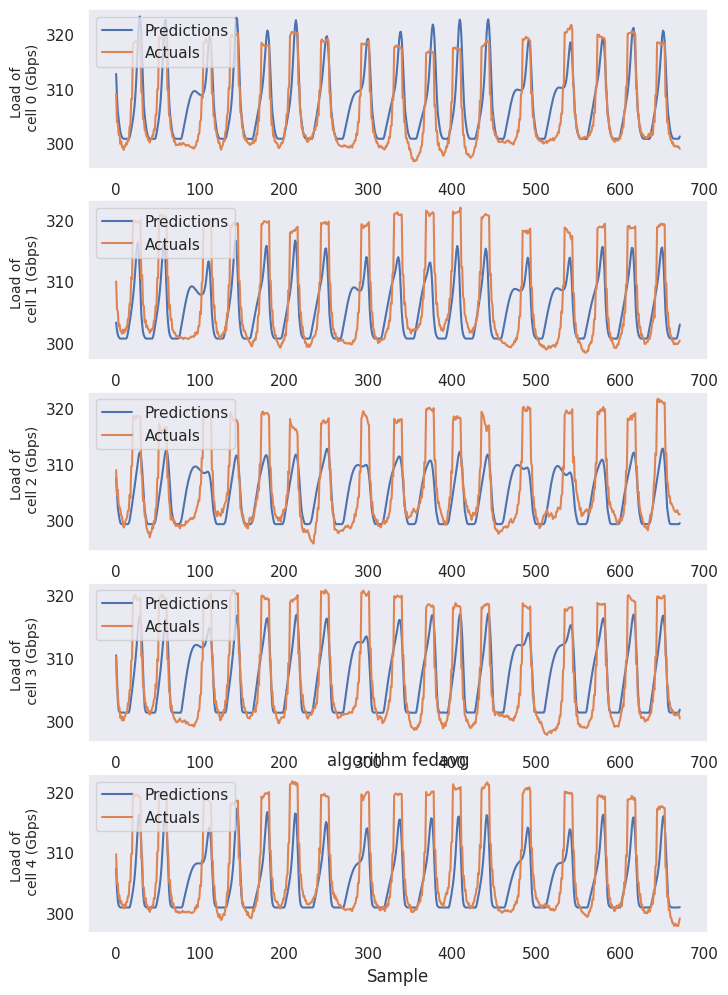

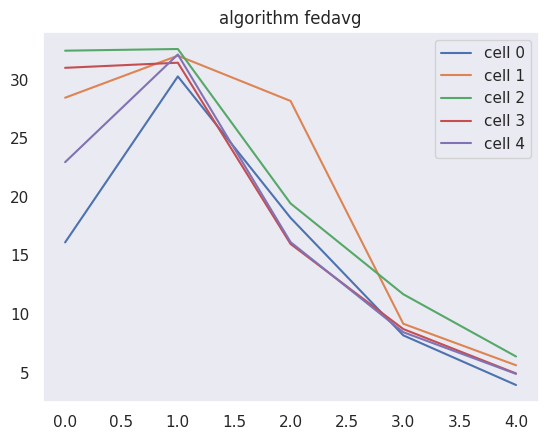

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedadam is created!
Epoch 1/2
48/48 - 12s - loss: 0.0955 - root_mean_squared_error: 0.3091 - val_loss: 0.0700 - val_root_mean_squared_error: 0.2646 - 12s/epoch - 249ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.0493 - val_root_mean_squared_error: 0.2220 - 4s/epoch - 92ms/step
30/30 [==============================] - 1s 33ms/step
Client 2 test loss in round 1 is 33.112076511878705
Client 2 train loss in round 1 is 36.50356722900435
Epoch 1/2
48/48 - 12s - loss: 0.1274 - root_mean_squared_error: 0.3569 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3426 - 12s/epoch - 253ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2344 - 4s/epoch - 81ms/step
30/30 [==========

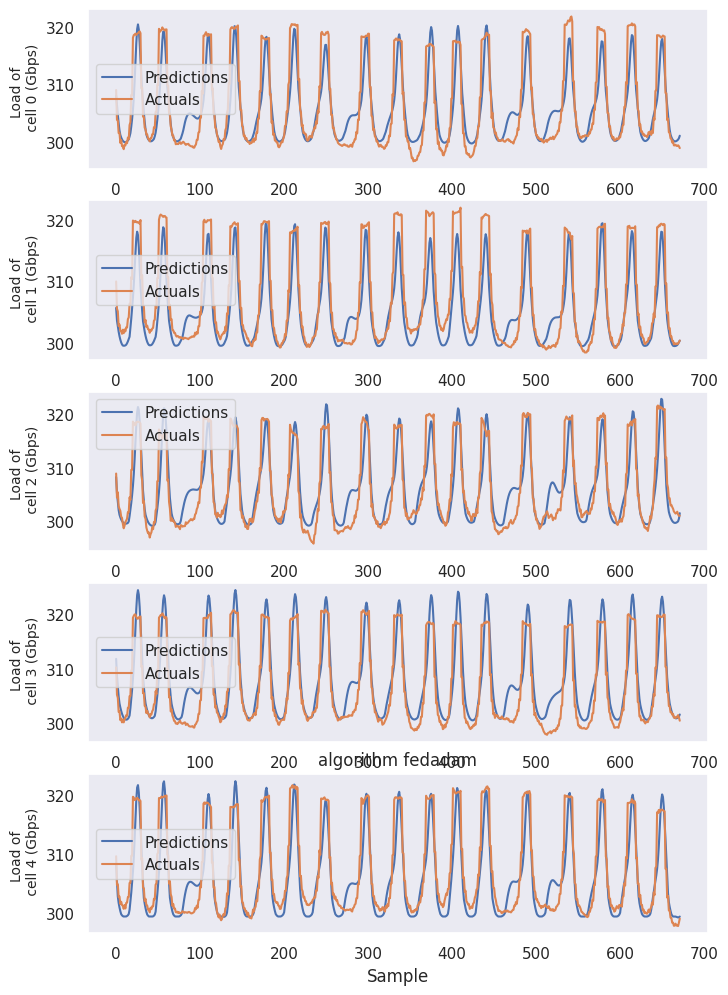

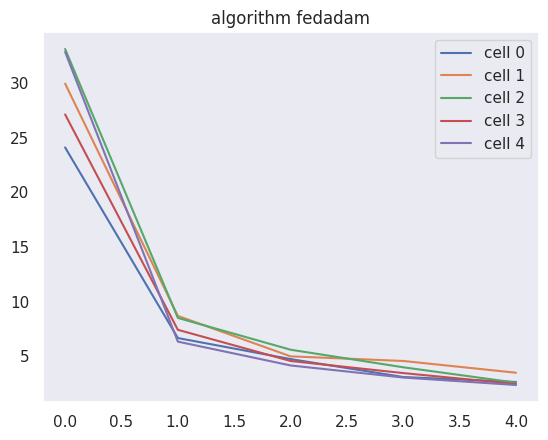

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedprox is created!
Epoch 1/2
48/48 - 13s - loss: 0.1212 - root_mean_squared_error: 0.3482 - val_loss: 0.0654 - val_root_mean_squared_error: 0.2558 - 13s/epoch - 263ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0623 - root_mean_squared_error: 0.2496 - val_loss: 0.0438 - val_root_mean_squared_error: 0.2093 - 4s/epoch - 82ms/step
30/30 [==============================] - 2s 57ms/step
Client 3 test loss in round 1 is 23.620326758529863
Client 3 train loss in round 1 is 26.702248379739963
Epoch 1/2
48/48 - 14s - loss: 0.1152 - root_mean_squared_error: 0.3394 - val_loss: 0.0873 - val_root_mean_squared_error: 0.2955 - 14s/epoch - 285ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0642 - root_mean_squared_error: 0.2534 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958 - 4s/epoch - 88ms/step
30/30 [=========

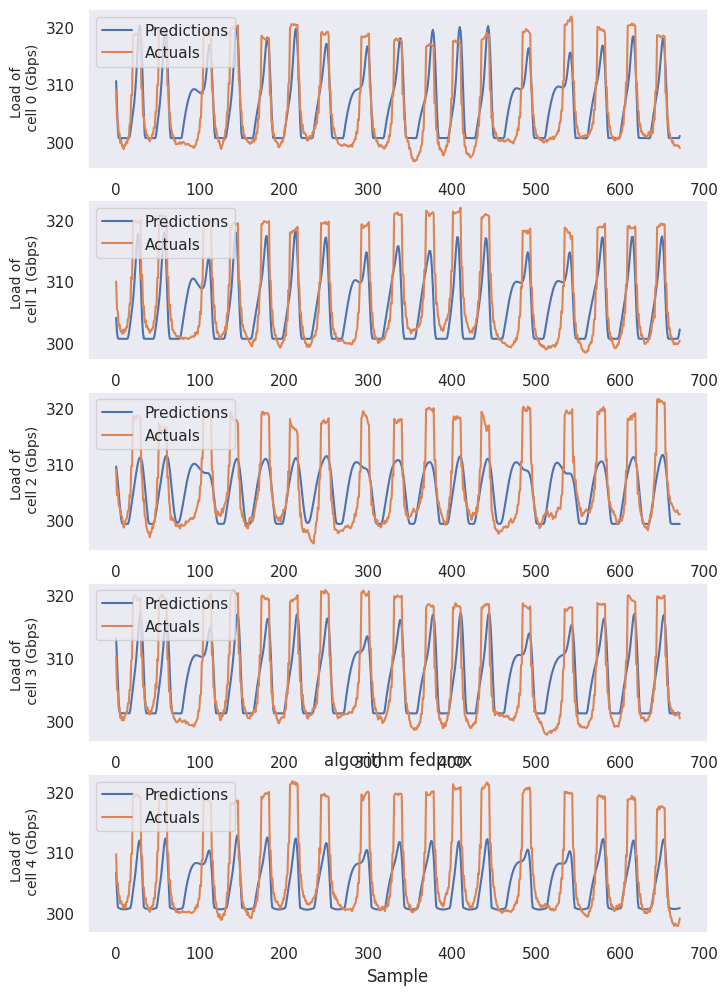

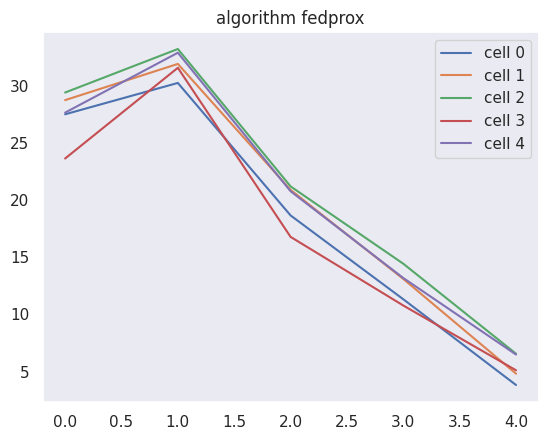

AttributeError: ignored

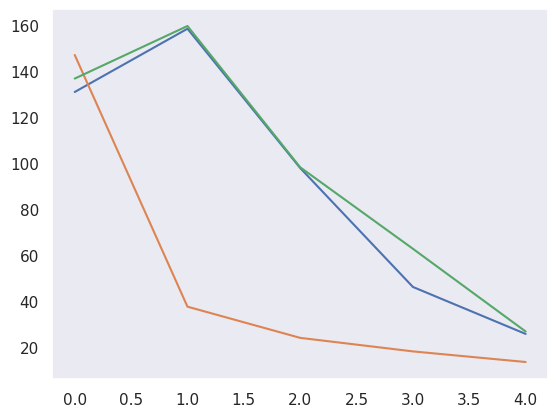

In [ ]:
# Run Federated for each algorithm with 5 client and without attack
global_test_loss = dict()
global_train_loss = dict()

for alg in algorithms:
  clients =initialize_clients(num_clients=5, n_epoch=2, attack_rate=0)
  server = Server(clients=clients, aggregation=alg)
  server.fit(num_rounds=5, fraction=1)
  plot_load_cell(clients, alg)
  plot_cell_loss(clients, server.test_losses, alg)
  global_test_loss[alg] = calculate_global_loss(clients, server.test_losses)
  global_train_loss[alg] = calculate_global_loss(clients, server.train_losses)

plot_global_test_loss(algorithms, global_test_loss)
plot_global_train_loss(algorithms, global_train_loss)

In [ ]:
# Last test loss for FedProx = 26.7379925
3.812566853647362+5.099351266060923+4.803281079248088+6.546992761198536+6.475800549007128
# Last test loss for FedAdam = 13.4563805
2.562949468395154+2.627044864442763+2.3497896810782946+2.442356397338963+3.4742400916836855
# Last test loss for FedAvg = 25.6805618
4.910646492361477+4.876504959182386+3.9232519704333604+5.610237915642211+6.359920476780148

In [ ]:
# Last train loss for FedProx = 28.4163856
4.34071545240738+5.354316229601669+4.934250050033601+7.5063255122053905+6.2807783217165145
# Last train loss for FedAdam = 14.0918497
2.835733100277263+2.91984904237564+2.460323881164174+2.723845649846942+3.152097982716902
# Last train loss for FedAvg = 27.6597409
5.3783057402352235+4.878225415496269+4.160514288076077+5.560795753993484+7.6818997241043565

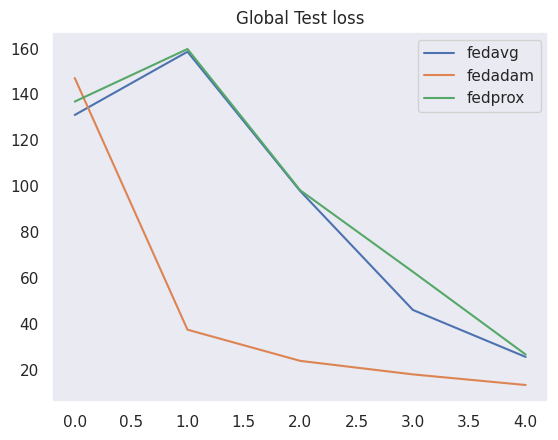

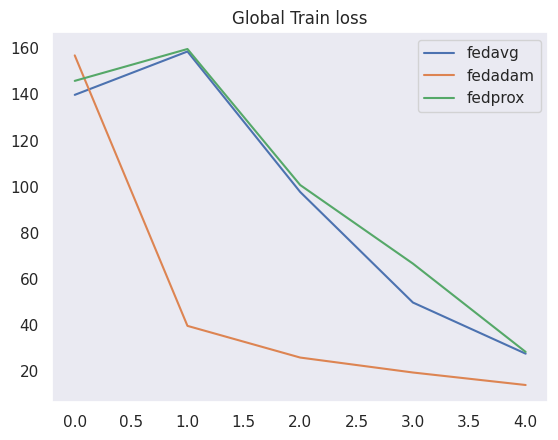

In [ ]:
plot_global_test_loss(algorithms, global_test_loss)
plot_global_train_loss(algorithms, global_train_loss)

# Proof of algorithem
## Run algorithem FedAvg with 5 clients and 10 epoch Without attack

In [ ]:
clients =initialize_clients(num_clients=5,n_epoch=10, attack_rate=0)

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!


In [ ]:
server = Server(clients=clients, aggregation="fedavg")

server with 5 clients and aggregation algorithm fedavg is created!


In [ ]:
server.fit(num_rounds=5, fraction=1)

Epoch 1/10
48/48 - 16s - loss: 0.1046 - root_mean_squared_error: 0.3234 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522 - 16s/epoch - 329ms/step
Epoch 2/10
48/48 - 4s - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1899 - 4s/epoch - 89ms/step
Epoch 3/10
48/48 - 5s - loss: 0.0466 - root_mean_squared_error: 0.2158 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1583 - 5s/epoch - 98ms/step
Epoch 4/10
48/48 - 4s - loss: 0.0377 - root_mean_squared_error: 0.1941 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438 - 4s/epoch - 79ms/step
Epoch 5/10
48/48 - 4s - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1346 - 4s/epoch - 78ms/step
Epoch 6/10
48/48 - 5s - loss: 0.0286 - root_mean_squared_error: 0.1693 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236 - 5s/epoch - 106ms/step
Epoch 7/10
48/48 - 4s - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0146 

[array([[ 0.07395224,  0.00521191, -0.06742284,  0.02022951,  0.1683356 ,
          0.03064815,  0.05330972,  0.04420413,  0.07075888, -0.0202853 ,
          0.03554489,  0.04288518,  0.04694669,  0.04847464,  0.02103155,
          0.06906717,  0.01965346,  0.00062381,  0.04394752,  0.05501526,
          0.03409909,  0.00293546,  0.04495919,  0.06125817,  0.04920948,
         -0.01137976,  0.11141566,  0.09599307, -0.01130066, -0.00074862,
          0.0652225 ,  0.0472162 ,  0.05297071,  0.02055554,  0.09025668,
         -0.01743806,  0.01663714,  0.03816054,  0.02504994,  0.038334  ,
         -0.04414281,  0.04427711,  0.02914693,  0.12393725,  0.10561116,
          0.00817863,  0.17145982, -0.02212021,  0.03981947,  0.05945185,
          0.09920581, -0.03050305,  0.03059759,  0.02232189,  0.04983082,
          0.04459403,  0.00710203,  0.00854784,  0.03901288, -0.02093481,
         -0.00373015,  0.05220482,  0.0243339 ,  0.04536848,  0.04416459,
         -0.09842414,  0.0002    ,  0.

30/30 [==============================] - 1s 36ms/step
MSE for cell 0:  1.79695165569107
30/30 [==============================] - 1s 36ms/step
MSE for cell 1:  2.106152083682572
30/30 [==============================] - 1s 35ms/step
MSE for cell 2:  2.676940717494719
30/30 [==============================] - 1s 35ms/step
MSE for cell 3:  1.6771544292821687
30/30 [==============================] - 1s 43ms/step
MSE for cell 4:  2.6332264167515427


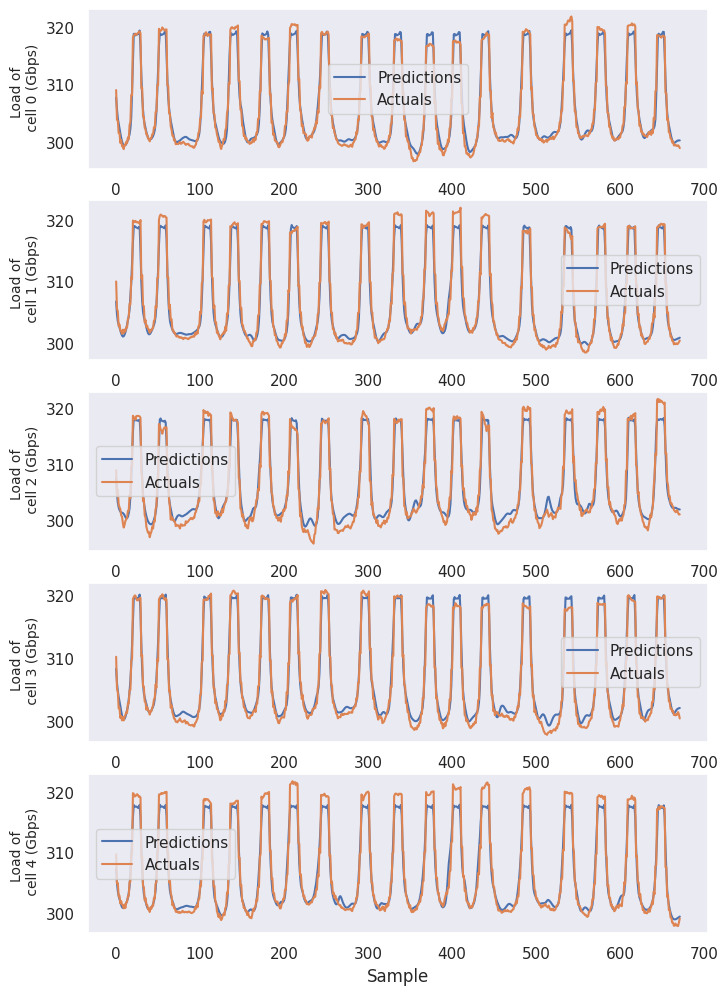

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()

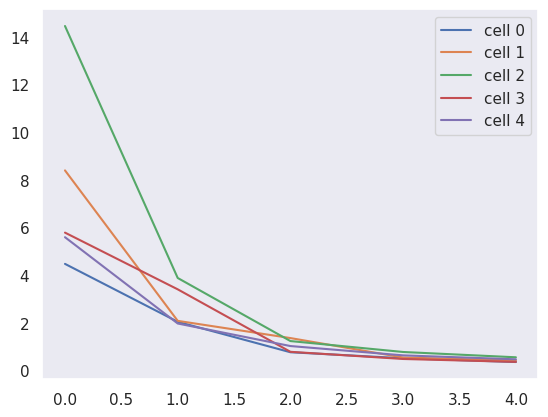

In [ ]:
for cid in range(len(clients)):
  plt.plot(server.test_losses[cid],label=f"cell {cid}")
plt.legend()

# Impact of attacks

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedavg is created!
client 2 is using adversarial attacks
118/118 [==============================] - 8s 39ms/step
Epoch 1/2
48/48 - 15s - loss: 0.1069 - root_mean_squared_error: 0.3270 - val_loss: 0.0877 - val_root_mean_squared_error: 0.2962 - 15s/epoch - 313ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0664 - root_mean_squared_error: 0.2577 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2074 - 4s/epoch - 83ms/step
30/30 [==============================] - 1s 37ms/step
Client 2 test loss in round 1 is 32.20577783186732
Client 2 train loss in round 1 is 34.32513885918214
client 4 is using adversarial attacks
118/118 [==============================] - 7s 46ms/step
Epoch 1/2
48/48 - 13s - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2154 - 13s/

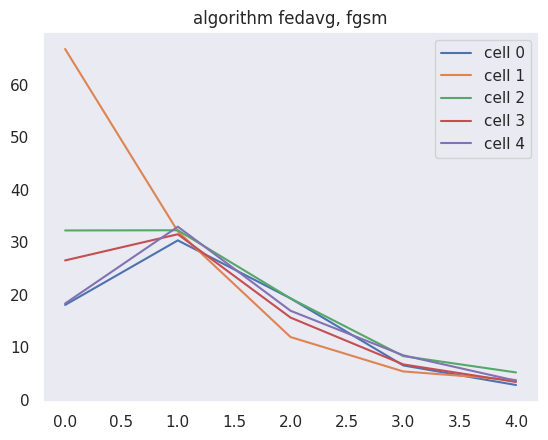

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedadam is created!
client 0 is using adversarial attacks
118/118 [==============================] - 6s 33ms/step
Epoch 1/2
48/48 - 12s - loss: 0.1333 - root_mean_squared_error: 0.3652 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2600 - 12s/epoch - 258ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0884 - root_mean_squared_error: 0.2973 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2036 - 4s/epoch - 86ms/step
30/30 [==============================] - 1s 33ms/step
Client 0 test loss in round 1 is 26.62123089848715
Client 0 train loss in round 1 is 30.441084125763286
Epoch 1/2
48/48 - 12s - loss: 0.1173 - root_mean_squared_error: 0.3425 - val_loss: 0.0707 - val_root_mean_squared_error: 0.2659 - 12s/epoch - 259ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0667 - root_mean_squared_error: 0.2583 - v

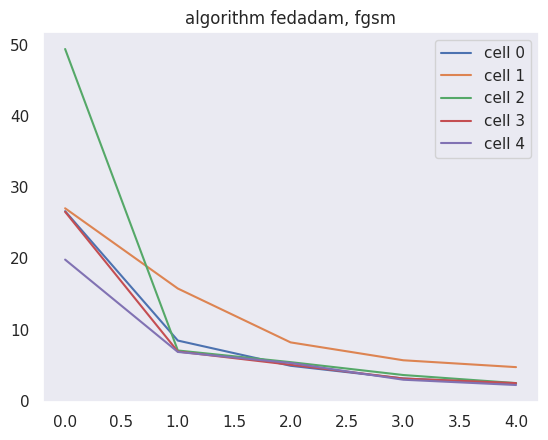

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedprox is created!
client 3 is using adversarial attacks
118/118 [==============================] - 5s 34ms/step
Epoch 1/2
48/48 - 13s - loss: 0.1095 - root_mean_squared_error: 0.3309 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230 - 13s/epoch - 261ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0543 - root_mean_squared_error: 0.2330 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1813 - 4s/epoch - 76ms/step
30/30 [==============================] - 1s 33ms/step
Client 3 test loss in round 1 is 16.754051309364694
Client 3 train loss in round 1 is 19.3950134164449
client 1 is using adversarial attacks
118/118 [==============================] - 6s 40ms/step
Epoch 1/2
48/48 - 17s - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 17s

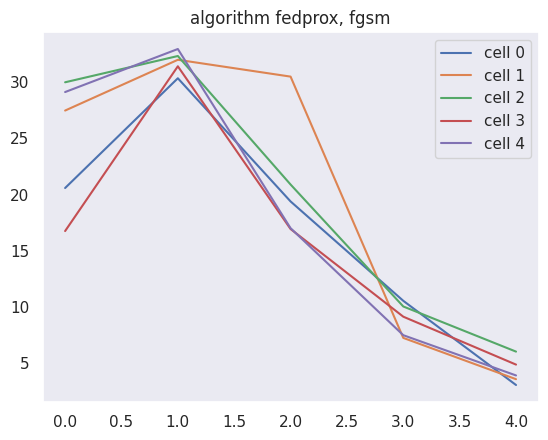

In [31]:
# Run Federated for each algorithm with 5 client and with fgsm attack
global_test_loss_fgsm = dict()
global_train_loss_fgsm = dict()
for alg in algorithms:
  clients =initialize_clients(num_clients=5, n_epoch=2, attack_rate=0.5, attack="fgsm")
  server = Server(clients=clients, aggregation=alg)
  server.fit(num_rounds=5, fraction=1)
  # plot_load_cell(clients, alg)
  plot_cell_loss(clients, server.test_losses, f"{alg}, fgsm")
  global_test_loss_fgsm[alg] = calculate_global_loss(clients, server.test_losses)
  global_train_loss_fgsm[alg] = calculate_global_loss(clients, server.train_losses)


In [32]:
global_test_loss_fgsm

{'fedavg': array([161.77290124, 158.97960123,  83.00280838,  35.32795506,
         18.70791558]),
 'fedadam': array([149.42592571,  44.94631577,  28.77583629,  18.37925612,
         14.14792807]),
 'fedprox': array([123.88818414, 158.96385432, 104.70662149,  44.49593352,
         21.49471319])}

<function matplotlib.pyplot.show(close=None, block=None)>

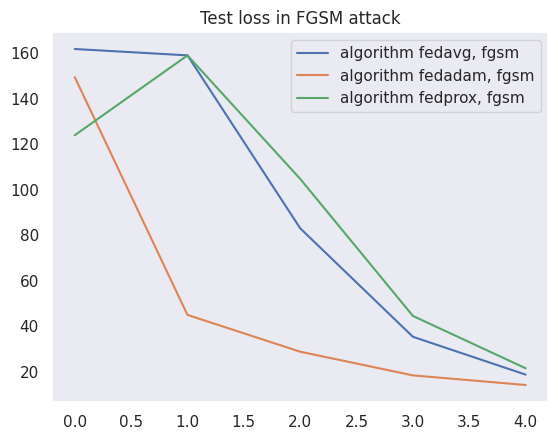

In [38]:
for alg in algorithms:
  plt.plot(global_test_loss_fgsm[alg],label=f"algorithm {alg}, fgsm")
plt.legend()
plt.title("Test loss in FGSM attack")
plt.show

In [33]:
global_train_loss_fgsm

{'fedavg': array([168.49857574, 158.04780113,  84.50742286,  37.86677222,
         20.27851015]),
 'fedadam': array([157.15614466,  45.39851471,  29.41894564,  19.0478474 ,
         14.40927413]),
 'fedprox': array([130.23182088, 158.46493741, 102.97037906,  48.64793126,
         24.10162129])}

<function matplotlib.pyplot.show(close=None, block=None)>

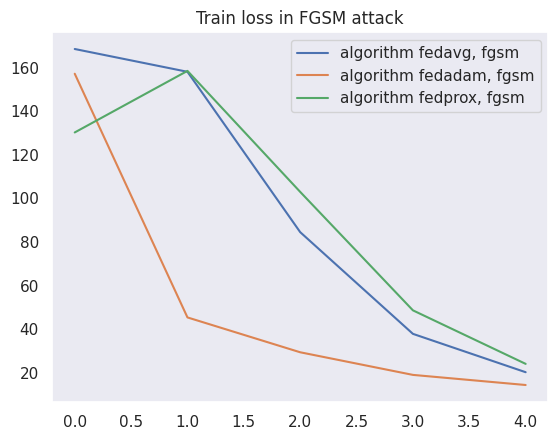

In [39]:
for alg in algorithms:
  plt.plot(global_train_loss_fgsm[alg],label=f"algorithm {alg}, fgsm")
plt.legend()
plt.title("Train loss in FGSM attack")
plt.show

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedavg is created!
client 1 is using adversarial attacks
118/118 [==============================] - 5s 34ms/step
Epoch 1/2
48/48 - 13s - loss: 0.1041 - root_mean_squared_error: 0.3226 - val_loss: 0.0453 - val_root_mean_squared_error: 0.2127 - 13s/epoch - 263ms/step
Epoch 2/2
48/48 - 5s - loss: 0.0563 - root_mean_squared_error: 0.2372 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869 - 5s/epoch - 111ms/step
30/30 [==============================] - 1s 33ms/step
Client 1 test loss in round 1 is 27.842786572558545
Client 1 train loss in round 1 is 26.65673166456792
client 4 is using adversarial attacks
118/118 [==============================] - 6s 42ms/step
Epoch 1/2
48/48 - 16s - loss: 0.1106 - root_mean_squared_error: 0.3325 - val_loss: 0.0603 - val_root_mean_squared_error: 0.2455 - 16

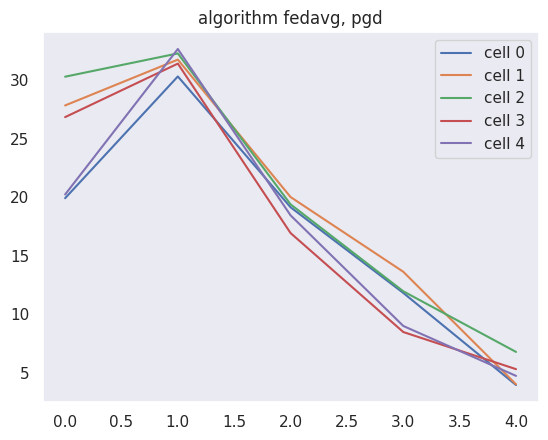

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedadam is created!
Epoch 1/2
48/48 - 18s - loss: 0.1304 - root_mean_squared_error: 0.3612 - val_loss: 0.0937 - val_root_mean_squared_error: 0.3061 - 18s/epoch - 378ms/step
Epoch 2/2
48/48 - 5s - loss: 0.0865 - root_mean_squared_error: 0.2941 - val_loss: 0.0487 - val_root_mean_squared_error: 0.2207 - 5s/epoch - 109ms/step
30/30 [==============================] - 1s 35ms/step
Client 4 test loss in round 1 is 29.140134567791016
Client 4 train loss in round 1 is 29.43117730475152
client 0 is using adversarial attacks
118/118 [==============================] - 7s 47ms/step
Epoch 1/2
48/48 - 13s - loss: 0.1103 - root_mean_squared_error: 0.3321 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2143 - 13s/epoch - 267ms/step
Epoch 2/2
48/48 - 5s - loss: 0.0646 - root_mean_squared_error: 0.2541 - 

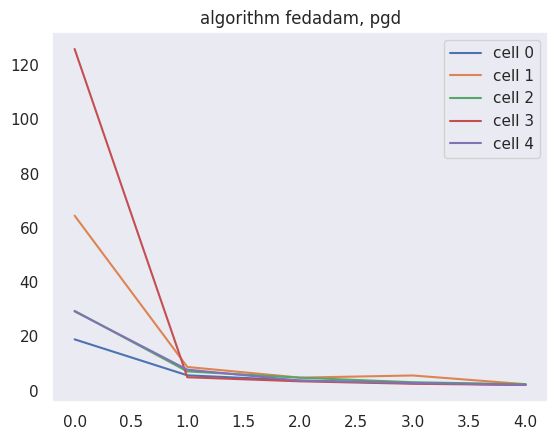

Initializing clients ...
client 0 initilized.
client 1 initilized.
client 2 initilized.
client 3 initilized.
client 4 initilized.
Clients initialized!
server with 5 clients and aggregation algorithm fedprox is created!
client 3 is using adversarial attacks
118/118 [==============================] - 6s 41ms/step
Epoch 1/2
48/48 - 13s - loss: 0.1309 - root_mean_squared_error: 0.3618 - val_loss: 0.0866 - val_root_mean_squared_error: 0.2943 - 13s/epoch - 269ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0812 - root_mean_squared_error: 0.2849 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2146 - 4s/epoch - 82ms/step
30/30 [==============================] - 1s 40ms/step
Client 3 test loss in round 1 is 27.604034498001354
Client 3 train loss in round 1 is 30.177934432221697
Epoch 1/2
48/48 - 12s - loss: 0.1078 - root_mean_squared_error: 0.3283 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2566 - 12s/epoch - 254ms/step
Epoch 2/2
48/48 - 4s - loss: 0.0675 - root_mean_squared_error: 0.2597 - 

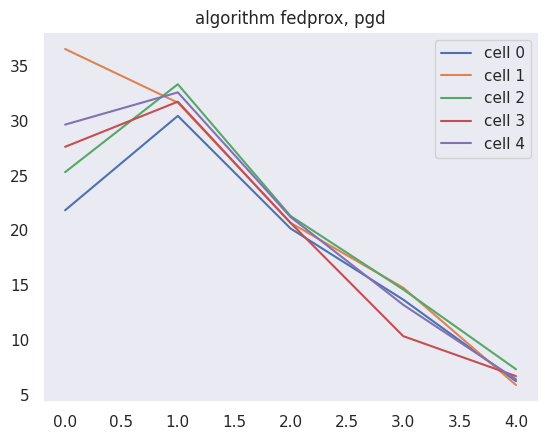

In [34]:
# Run Federated for each algorithm with 5 client and with fgsm attack
global_test_loss_pgd = dict()
global_train_loss_pgd = dict()
for alg in algorithms:
  clients =initialize_clients(num_clients=5, n_epoch=2, attack_rate=0.5, attack="pgd")
  server = Server(clients=clients, aggregation=alg)
  server.fit(num_rounds=5, fraction=1)
  # plot_load_cell(clients, alg)
  plot_cell_loss(clients, server.test_losses, f"{alg}, pgd")
  global_test_loss_pgd[alg] = calculate_global_loss(clients, server.test_losses)
  global_train_loss_pgd[alg] = calculate_global_loss(clients, server.train_losses)


In [35]:
global_test_loss_pgd

{'fedavg': array([125.1411697 , 158.45228321,  93.94802621,  54.90810934,
         24.80797539]),
 'fedadam': array([267.58702157,  33.66194084,  19.93400181,  16.29945249,
         10.67837262]),
 'fedprox': array([140.86108881, 159.61536654, 104.0490889 ,  66.66851125,
         32.73013647])}

<function matplotlib.pyplot.show(close=None, block=None)>

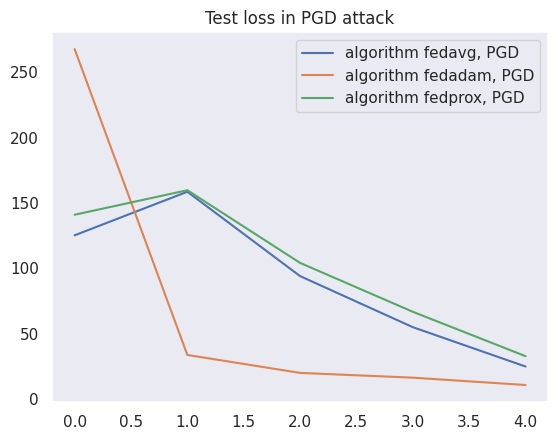

In [41]:
for alg in algorithms:
  plt.plot(global_test_loss_pgd[alg],label=f"algorithm {alg}, PGD")
plt.legend()
plt.title("Test loss in PGD attack")
plt.show

In [36]:
global_train_loss_pgd

{'fedavg': array([134.44778388, 158.18441574,  95.34969846,  57.03716611,
         27.49707151]),
 'fedadam': array([260.56219537,  32.6310523 ,  21.44826304,  16.33037215,
         11.26596289]),
 'fedprox': array([146.51572595, 159.61769889, 104.41591939,  69.11885441,
         35.97803228])}

<function matplotlib.pyplot.show(close=None, block=None)>

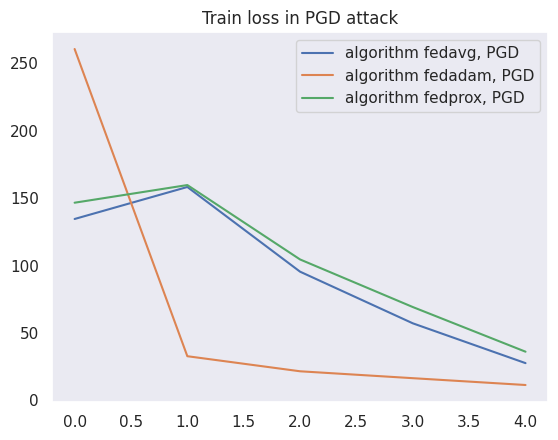

In [42]:
for alg in algorithms:
  plt.plot(global_train_loss_pgd[alg],label=f"algorithm {alg}, PGD")
plt.legend()
plt.title("Train loss in PGD attack")
plt.show